# Forecasting COVID-19
In this notebook we show some preliminary results of forecasting the spread of the SARS-CoV-2 virus in China. We use a recurrent deep learning model to learn and predict the total number of cases in various provinces of China.

In [1]:
SEED = 42
import random
random.seed(SEED)
# Data reading
import csv
# File path manipulation
from os.path import join as pjoin
# Ordered dictionary data structure
from collections import OrderedDict
# Data manipulation and file loading
import pandas as pd
import numpy as np
np.random.seed(SEED)
# Plotting
import matplotlib.pyplot as plt
# Keras model and layers
import tensorflow as tf
tf.random.set_seed(SEED)
from keras.models import Model
from keras.layers import Dense, LSTM, Concatenate, Lambda, Input, Multiply
from keras.layers.merge import Average
# Preprocessing
from sklearn.preprocessing import MinMaxScaler

Using TensorFlow backend.


In [2]:
DATA_DIR = pjoin('..', 'data')

### Data Parsing
Here we read in the `Covid_ChinaM_raw.csv` CSV file - the first row contains the countries with corresponding populations and the second is a header with four attributes per country: 'Active', 'Total', 'Pop', 'Med'. We read the data into a `Pandas DataFrame` with a hierarchical index.

In [3]:
# Read in the CSV
with open(pjoin(DATA_DIR, 'Covid_ChinaM_raw.csv'), 'r') as f:
    csv_reader = csv.reader(f, delimiter=',')
    # First row of CSV contains country names and population information
    meta_row = next(csv_reader)
    # Data is four repeating headers per country: Active, Total, Pop, Med
    sub_header = next(csv_reader)[:4]
    # Read in each row as floats
    csv_data = [list(map(float, row)) for row in csv_reader]

# Dictionary mapping country name to population size (preserves order)
pop_dict = OrderedDict([
    (meta_row[i], int(meta_row[i + 1]))
    for i in range(0, len(meta_row), 2) if meta_row[i]
])
provinces = list(pop_dict.keys())
# A hierarchical index with the 4 attributes for each province
columns = pd.MultiIndex.from_product([provinces, sub_header],
                                     names=['province', 'feature'])
# Create a pandas dataframe and print some of the data
df = pd.DataFrame(csv_data, columns=columns, dtype=np.float32)
df.head()

province      Shanghai                                      Zhejiang  \
feature         Active         Total     Pop       Med        Active   
0         3.712870e-07  3.712870e-07  3813.0  0.811229  1.743070e-07   
1         6.600660e-07  6.600660e-07  3813.0  0.811229  4.706290e-07   
2         7.838280e-07  8.250830e-07  3813.0  0.811229  7.495210e-07   
3         1.320130e-06  1.361390e-06  3813.0  0.811229  1.080700e-06   
4         1.567660e-06  1.650170e-06  3813.0  0.811229  1.812790e-06   

province                                     Jiangsu                ...  \
feature          Total    Pop      Med        Active         Total  ...   
0         1.743070e-07  560.0  0.31352  1.243780e-08  1.243780e-08  ...   
1         4.706290e-07  560.0  0.31352  6.218910e-08  6.218910e-08  ...   
2         7.495210e-07  560.0  0.31352  1.119400e-07  1.119400e-07  ...   
3         1.080700e-06  560.0  0.31352  2.238810e-07  2.238810e-07  ...   
4         1.812790e-06  560.0  0.31352  4.104480e-07  4.104480e-07  ...   

province  Hebei            Heilongjiang                                \
feature     Pop       Med        Active         Total   Pop       Med   
0         400.0  0.431071  0.000000e+00  0.000000e+00  83.0  0.044676   
1         400.0  0.431071  7.057160e-08  7.057160e-08  83.0  0.044676   
2         400.0  0.431071  1.058570e-07  1.411430e-07  83.0  0.044676   
3         400.0  0.431071  2.822870e-07  3.175720e-07  83.0  0.044676   
4         400.0  0.431071  4.940010e-07  5.292870e-07  83.0  0.044676   

province         Henan                                 
feature         Active         Total    Pop       Med  
0         5.230670e-08  5.230670e-08  572.0  0.425683  
1         5.230670e-08  5.230670e-08  572.0  0.425683  
2         9.415210e-08  9.415210e-08  572.0  0.425683  
3         3.347630e-07  3.347630e-07  572.0  0.425683  
4         8.578300e-07  8.682920e-07  572.0  0.425683  

[5 rows x 68 columns]

In [4]:
# Grab all the data of each attribute
data_act = df.loc(axis=1)[:, 'Active'].values
data_tot = df.loc(axis=1)[:, 'Total'].values
data_pop = df.loc(axis=1)[:, 'Pop'].values
data_med = df.loc(axis=1)[:, 'Med'].values

# Normalize the temporal data in the DataFrame (country-wise)
scaler_act = MinMaxScaler(feature_range=(0, 1))
scaler_tot = MinMaxScaler(feature_range=(0, 1))

data_act = scaler_act.fit_transform(data_act)
data_tot = scaler_tot.fit_transform(data_tot)

### Data Formatting
Here, we convert the data to sequences with a "look-back" parameter. This simply creates sequences of such a size that are fed to the model to learn to predict the next value. In this case, we use 5 days of data to predict the day directly proceeding.

In [5]:
# Convert time-series into LSTM training set
def create_dataset(dataset, ns, look_back=1):
    x_data, y_data = [], []
    for c in ns:
        data_seq = dataset[:, c]
        for i in range(len(data_seq) - look_back):
            x_data.append(data_seq[i:(i + look_back)])
            y_data.append(data_seq[i + look_back])
    return np.asarray(x_data), np.asarray(y_data)

In [6]:
# reshape into X=t and Y=t+1
look_back = 5

indices = list(range(13))
train_active, target_active = create_dataset(data_act,
                                             indices,
                                             look_back)
train_total, target_total = create_dataset(data_tot,
                                           indices,
                                           look_back)
train_pop, target_pop = create_dataset(data_pop,
                                       indices,
                                       look_back)
train_med, target_med = create_dataset(data_med,
                                       indices,
                                       look_back)

# Manual minmax scale for population density and hospital density
max_pop = np.max(target_pop)
min_pop = np.min(train_pop)
train_pop = (train_pop - min_pop) / (max_pop - min_pop)
target_pop = (target_pop - min_pop) / (max_pop - min_pop)

max_med = np.max(target_med)
min_med = np.min(train_med)
train_med = (train_med - min_med) / (max_med - min_med)
target_med = (target_med - min_med) / (max_med - min_med)

In [7]:
# Concatenate data together into final train data format
x_train = np.stack((train_active, train_total, train_pop, train_med),
                   axis=-1)
y_train = np.stack((target_active, target_total),
                   axis=-1)

### Model Definition
Here we define a custom small LSTM architecture that integrates two temporal inputs and combines the two static attributes.

In [8]:
MODEL = 3  # The best-performing architecture without tuning

# create and fit the LSTM network
nf_time = 2  # number of features changing with time
nf_all = x_train.shape[-1]  # 4 total features

# Number of ensemble models (take average over all outputs)
N_ENSEMBLE = 3

all_inputs = Input(shape=(look_back, nf_all))
model_outputs = []
for i in range(N_ENSEMBLE):
    # The recurrent input
    rec_input = Lambda(
        lambda x: x[:, :, :nf_time],
        name='rec_in_' + str(i)
    )(all_inputs)
    # The LSTM
    h = LSTM(
        20, input_shape=(look_back, nf_time)
    )(rec_input)

    if MODEL == 1:  # Model 1
        use_dense2 = True
        split_feats = False
        merge_layer = Multiply
    elif MODEL == 2:  # Model 2
        use_dense2 = True
        split_feats = True
        merge_layer = Multiply
    elif MODEL == 3:  # Model 3
        use_dense2 = False
        split_feats = True
        merge_layer = Concatenate
    elif MODEL == 4:  # Model 4
        use_dense2 = True
        split_feats = False
        merge_layer = Concatenate
    elif MODEL == 5:  # Model 5
        use_dense2 = True
        split_feats = True
        merge_layer = Concatenate
    else:
        raise NotImplementedError(MODEL)

    # Input of the merge layer
    merge_input = Lambda(
        lambda x: x[:, 0, nf_time:] if split_feats else x[:, 0, :],
        name='merge_in_' + str(i)
    )(all_inputs)
    # Dense layer for input 0 before merge
    if use_dense2:
        merge_input = Dense(20, activation='softmax')(merge_input)
    # Merge the dense output with the recurrent output
    merged = merge_layer()([h, merge_input])
    # 2 outputs being predicted (active & total)
    out = Dense(2)(merged)
    model_outputs.append(out)

# Create the Keras Model and print a summary
CoVid = Model(inputs=all_inputs,
              outputs=Average()(model_outputs))
CoVid.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 5, 4)         0                                            
__________________________________________________________________________________________________
rec_in_0 (Lambda)               (None, 5, 2)         0           input_1[0][0]                    
__________________________________________________________________________________________________
rec_in_1 (Lambda)               (None, 5, 2)         0           input_1[0][0]                    
__________________________________________________________________________________________________
rec_in_2 (Lambda)               (None, 5, 2)         0           input_1[0][0]                    
____________________________________________________________________________________________

### Model Visualization
If you have the `pydot` Python package installed, we can use Keras' `plot_model` utility to visualize the model layers and connectivity.

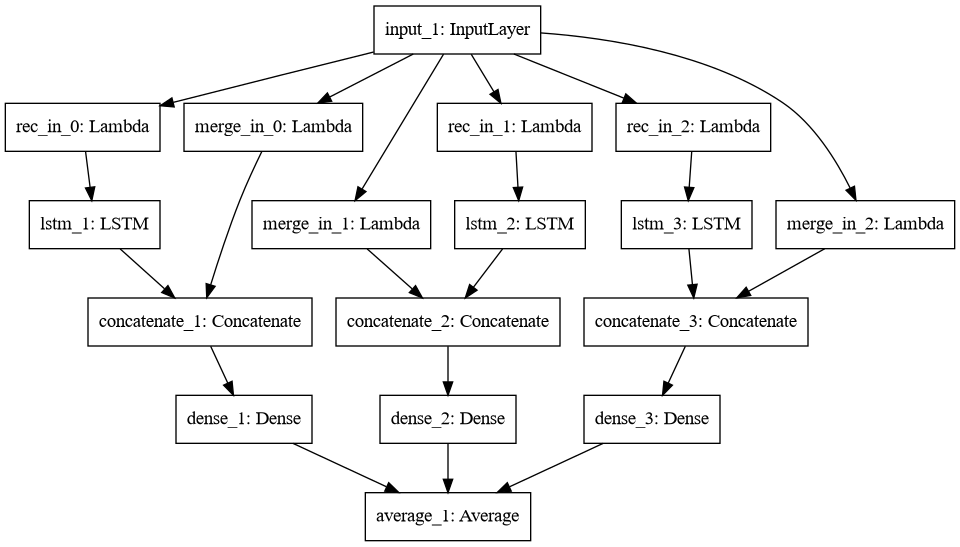

In [9]:
from keras.utils import plot_model
plot_model(CoVid)

### Training
Now, we compile the model with the Mean-Squared-Error loss function and the Adam optimization algorithm based on gradient descent. We then fit the training data.

In [10]:
CoVid.compile(loss='mean_squared_error', optimizer='adam')
_ = CoVid.fit(x_train, y_train, epochs=100, batch_size=50, verbose=2)

Epoch 1/100
 - 1s - loss: 0.5767
Epoch 2/100
 - 0s - loss: 0.3894
Epoch 3/100
 - 0s - loss: 0.2434
Epoch 4/100
 - 0s - loss: 0.1286
Epoch 5/100
 - 0s - loss: 0.0584
Epoch 6/100
 - 0s - loss: 0.0382
Epoch 7/100
 - 0s - loss: 0.0338
Epoch 8/100
 - 0s - loss: 0.0273
Epoch 9/100
 - 0s - loss: 0.0227
Epoch 10/100
 - 0s - loss: 0.0183
Epoch 11/100
 - 0s - loss: 0.0146
Epoch 12/100
 - 0s - loss: 0.0114
Epoch 13/100
 - 0s - loss: 0.0091
Epoch 14/100
 - 0s - loss: 0.0077
Epoch 15/100
 - 0s - loss: 0.0069
Epoch 16/100
 - 0s - loss: 0.0064
Epoch 17/100
 - 0s - loss: 0.0061
Epoch 18/100
 - 0s - loss: 0.0059
Epoch 19/100
 - 0s - loss: 0.0057
Epoch 20/100
 - 0s - loss: 0.0056
Epoch 21/100
 - 0s - loss: 0.0055
Epoch 22/100
 - 0s - loss: 0.0054
Epoch 23/100
 - 0s - loss: 0.0053
Epoch 24/100
 - 0s - loss: 0.0052
Epoch 25/100
 - 0s - loss: 0.0052
Epoch 26/100
 - 0s - loss: 0.0051
Epoch 27/100
 - 0s - loss: 0.0051
Epoch 28/100
 - 0s - loss: 0.0050
Epoch 29/100
 - 0s - loss: 0.0050
Epoch 30/100
 - 0s - lo

43/43 [==============================] - 0s 3ms/step
0.0015259484278557951
43/43 [==============================] - 0s 43us/step
0.0019088810198767067
43/43 [==============================] - 0s 55us/step
0.002531246391807271
43/43 [==============================] - 0s 80us/step
0.0014826547229922441


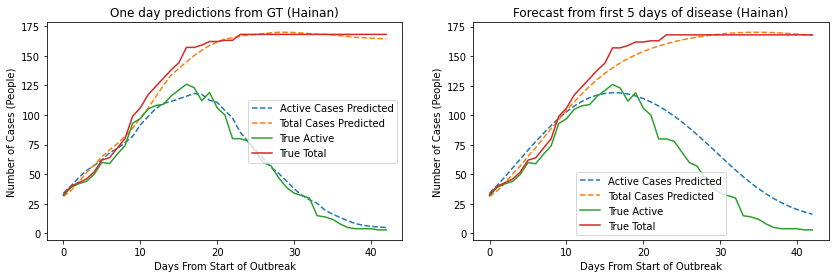

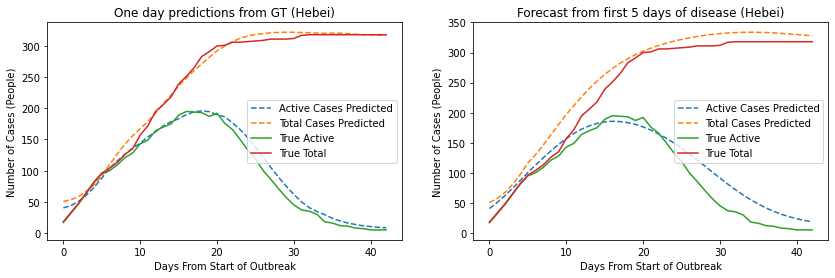

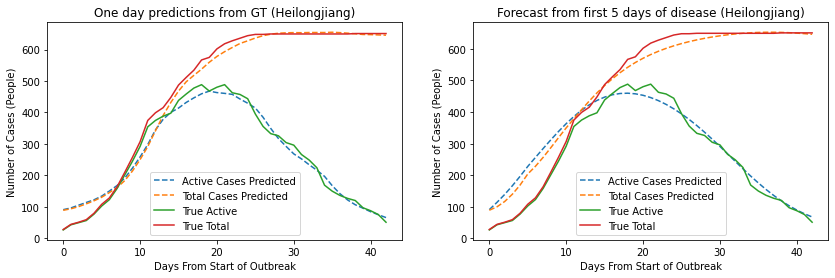

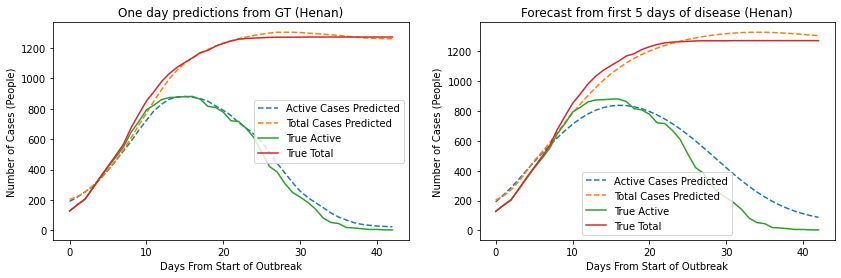

In [11]:
# Values for transforming normalized data to number of people
popV = [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9260000, 74700000, 38340000,
        95590000]
rangeA = scaler_act.data_range_
minA = scaler_act.data_min_
rangeT = scaler_tot.data_range_
minT = scaler_tot.data_min_

for r in [13, 14, 15, 16]:
    # Create test data for specific region
    test_active, target_activeT = create_dataset(data_act, [r], look_back)
    test_total, target_totalT = create_dataset(data_tot, [r], look_back)
    test_pop, target_popT = create_dataset(data_pop, [r], look_back)
    test_med, target_medT = create_dataset(data_med, [r], look_back)

    # Scale population density and hospital density
    test_pop = (test_pop - min_pop) / (max_pop - min_pop)
    target_popT = (target_popT - min_pop) / (max_pop - min_pop)
    test_med = (test_med - min_med) / (max_med - min_med)
    target_medT = (target_medT - min_med) / (max_med - min_med)

    x_test = np.stack((test_active, test_total, test_pop, test_med),
                      axis=-1)
    y_test = np.stack((target_activeT, target_totalT),
                      axis=-1)

    # One-day predictions from test data
    test_predict = CoVid.predict(x_test)
    print('error:', CoVid.evaluate(x_test, y_test))

    # Set up initial data point for forecasting
    initX = x_test[0, :, :]
    initX = np.reshape(initX, (1, look_back, nf_all))

    # Place holder to store forecast values
    total_predict = np.zeros((1, x_test.shape[0]))
    active_predict = np.zeros((1, x_test.shape[0]))

    # Loop through duration of forecast
    for tp in range(len(test_active)):
        prevX = initX
        oi = prevX[0, 1:, :]
        # Predict next day's data points (active and total cases)
        single_predict = CoVid.predict(initX)

        # Reformat new data point to predict from
        ci = np.reshape(prevX[0, 0, nf_time:], (1, 2))
        complete_in = np.concatenate((single_predict, ci), axis=1)
        initX = np.concatenate((oi, complete_in), axis=0)
        initX = np.reshape(initX, (1, look_back, nf_all))

        # Store predictions
        total_predict[0, tp] = np.float32(single_predict[0][1])
        active_predict[0, tp] = np.float32(single_predict[0][0])

    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
    # Plot one-day predictions from GT
    ax1.plot(((test_predict[:, 0] * rangeA[r]) + minA[r]) * popV[r],
             linestyle='dashed')
    ax1.plot(((test_predict[:, 1] * rangeT[r]) + minT[r]) * popV[r],
             linestyle='dashed')
    ax1.plot(((y_test[:, 0] * rangeA[r]) + minA[r]) * popV[r])
    ax1.plot(((y_test[:, 1] * rangeT[r]) + minT[r]) * popV[r])

    ax1.set_xlabel('Days From Start of Outbreak')
    ax1.set_ylabel('Number of Cases (People)')
    ax1.set_title('One day predictions from GT ({})'.format(provinces[r]))
    ax1.legend(['Active Cases Predicted', 'Total Cases Predicted',
                'True Active', 'True Total'])

    # Plot forecast spread from initial data
    ax2.plot(((active_predict[0, :] * rangeA[r]) + minA[r]) * popV[r],
             linestyle='dashed')
    ax2.plot(((total_predict[0, :] * rangeT[r]) + minT[r]) * popV[r],
             linestyle='dashed')
    ax2.plot(((y_test[:, 0] * rangeA[r]) + minA[r]) * popV[r])
    ax2.plot(((y_test[:, 1] * rangeT[r]) + minT[r]) * popV[r])

    ax2.set_xlabel('Days From Start of Outbreak')
    ax2.set_ylabel('Number of Cases (People)')
    ax2.set_title('Forecast from first 5 days of disease '
                  '({})'.format(provinces[r]))
    ax2.legend(['Active Cases Predicted', 'Total Cases Predicted',
                'True Active', 'True Total'])
plt.show()